In [2]:
from keras.models import Model, Sequential
from keras.optimizers import Adam
from keras.layers import Dense, Dropout, Flatten, Convolution2D, MaxPooling2D,ZeroPadding2D
from keras.layers import Input, Lambda
from keras.utils import np_utils
from keras.datasets import mnist
from keras import backend as K
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [3]:
############## DATA ###########################

############## MODIFY #########################

# load and shape data as usual, but here we don't process class labels
# to one-hot encoding. In fact, we don't exactly use class labels
# during training, only while setting up the triplets.
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

###############################################


def get_image(label, test=False):
    """Choose an image from our training or test data with the
    given label."""
    if test:
        y = y_test; X = X_test
    else:
        y = y_train; X = X_train
    idx = np.random.randint(len(y))
    while y[idx] != label:
        # keep searching randomly!
        idx = np.random.randint(len(y))
    return X[idx]
    
def get_triplet(test=False):
    """Choose a triplet (anchor, positive, negative) of images
    such that anchor and positive have the same label and
    anchor and negative have different labels."""
    n = a = np.random.randint(10)
    while n == a:
        # keep searching randomly!
        n = np.random.randint(10)
    a, p = get_image(a, test), get_image(a, test)
    n = get_image(n, test)
    return a, p, n

def generate_triplets(test=False):
    """Generate an un-ending stream (ie a generator) of triplets for
    training or test."""
    while True:
        list_a = []
        list_p = []
        list_n = []

        for i in range(batch_size):
            a, p, n = get_triplet(test)
            list_a.append(a)
            list_p.append(p)
            list_n.append(n)
            
        A = np.array(list_a, dtype='float32')
        P = np.array(list_p, dtype='float32')
        N = np.array(list_n, dtype='float32')
        # a "dummy" label which will come in to our identity loss
        # function below as y_true. We'll ignore it.
        label = np.ones(batch_size)
        yield [A, P, N], label

11493376/11490434 [==============================] - 12s 1us/step


In [5]:
def identity_loss(y_true, y_pred):
    return K.mean(y_pred)

def triplet_loss(x, alpha = 0.2):
    # Triplet Loss function.
    anchor,positive,negative = x
    # distance between the anchor and the positive
    pos_dist = K.sum(K.square(anchor-positive),axis=1)
    # distance between the anchor and the negative
    neg_dist = K.sum(K.square(anchor-negative),axis=1)
    # compute loss
    basic_loss = pos_dist-neg_dist+alpha
    loss = K.maximum(basic_loss,0.0)
    return loss

def embedding_model():
  # Simple convolutional model 
  # used for the embedding model.
  model = Sequential()
  model.add(Convolution2D(32, (3, 3), activation='relu',
                        input_shape=(28,28,1)))
  model.add(Convolution2D(32, (3, 3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Dropout(0.25))
  model.add(Flatten())
  model.add(Dense(128, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(10))
  return model


def complete_model(base_model):
    # Create the complete model with three
    # embedding models and minimize the loss 
    # between their output embeddings
    input_1 = Input((imsize, imsize, 1))
    input_2 = Input((imsize, imsize, 1))
    input_3 = Input((imsize, imsize, 1))
        
    A = base_model(input_1)
    P = base_model(input_2)
    N = base_model(input_3)
   
    loss = Lambda(triplet_loss)([A, P, N]) 
    model = Model(inputs=[input_1, input_2, input_3], outputs=loss)
    model.compile(loss=identity_loss, optimizer=Adam(LR))
    return model

In [6]:
# Define aspects of the model and create instances of both the 
# test and train batch generators and the complete model.

imsize = 28
batch_size = 100
embedding_dim = 2 
LR = 0.0001
EPOCHS = 5
alpha = 0.2 

train_generator = generate_triplets()
test_generator = generate_triplets(test=True)
batch = next(train_generator)

base_model = embedding_model()
model = complete_model(base_model)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 10)           600810      input_1[0][0]                    
                                                                 input_2[0][0]              

2022-05-07 13:22:26.997069: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-07 13:22:26.998039: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 8. Tune using inter_op_parallelism_threads for best performance.


In [7]:
# Fit the model using triplet images provided by the train batch generator.
# Save the trained weights.
history = model.fit_generator(train_generator, 
                    validation_data=test_generator, 
                    epochs=20, 
                    verbose=2,steps_per_epoch=20, 
                    validation_steps=30)
model.save_weights('model.hdf5')

Epoch 1/20
 - 14s - loss: 0.1893 - val_loss: 0.1540
Epoch 2/20
 - 12s - loss: 0.1628 - val_loss: 0.1138
Epoch 3/20
 - 12s - loss: 0.1331 - val_loss: 0.0847
Epoch 4/20
 - 12s - loss: 0.1190 - val_loss: 0.0819
Epoch 5/20
 - 12s - loss: 0.1066 - val_loss: 0.0706
Epoch 6/20
 - 12s - loss: 0.1021 - val_loss: 0.0475
Epoch 7/20
 - 12s - loss: 0.0944 - val_loss: 0.0550
Epoch 8/20
 - 12s - loss: 0.0873 - val_loss: 0.0377
Epoch 9/20
 - 12s - loss: 0.0830 - val_loss: 0.0532
Epoch 10/20
 - 12s - loss: 0.0745 - val_loss: 0.0607
Epoch 11/20
 - 12s - loss: 0.0785 - val_loss: 0.0603
Epoch 12/20
 - 12s - loss: 0.0786 - val_loss: 0.0302
Epoch 13/20
 - 12s - loss: 0.0719 - val_loss: 0.0390
Epoch 14/20
 - 12s - loss: 0.0755 - val_loss: 0.0306
Epoch 15/20
 - 12s - loss: 0.0618 - val_loss: 0.0413
Epoch 16/20
 - 13s - loss: 0.0615 - val_loss: 0.0413
Epoch 17/20
 - 13s - loss: 0.0566 - val_loss: 0.0283
Epoch 18/20
 - 13s - loss: 0.0639 - val_loss: 0.0283
Epoch 19/20
 - 13s - loss: 0.0531 - val_loss: 0.0304
Ep

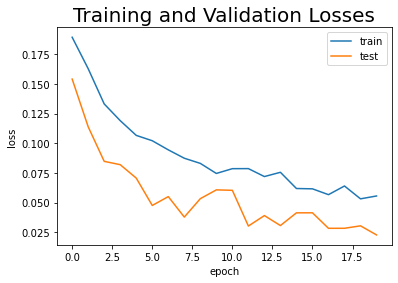

In [9]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training and Validation Losses',size = 20)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [10]:
# Using the newly trained model compute the embeddings 
# for a number images

sample_size = 5000

X_train_trm = base_model.predict(X_train[:sample_size].reshape(-1,28,28,1))
X_test_trm = base_model.predict(X_test[:sample_size].reshape(-1,28,28,1))

# TSNE to use dimensionality reduction to visulaise the resultant embeddings
tsne = TSNE()
train_tsne_embeds = tsne.fit_transform(X_train_trm)

/opt/anaconda3/envs/intro-ml/lib/python3.7/site-packages/ipykernel_launcher.py:16: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  app.launch_new_instance()


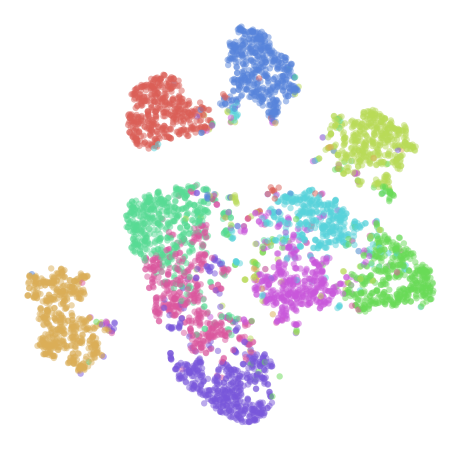

In [12]:
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import pandas as pd


def scatter(x, labels, subtitle=None):
    # Create a scatter plot of all the 
    # the embeddings of the model.
    # We choose a color palette with seaborn.
    palette = np.array(sns.color_palette("hls", 10))
    # We create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0,alpha = 0.5, s=40,
                    c=palette[labels.astype(np.int)] )
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')


scatter(train_tsne_embeds, y_train[:sample_size])

In [13]:
# Create a Classifier that computes the class of a specific embedding. 
Classifier_input = Input((10,))
Classifier_output = Dense(10, activation='softmax')(Classifier_input)
Classifier_model = Model(Classifier_input, Classifier_output)

# convert the target labels to onehot encoded vectors.
Y_train_onehot = np_utils.to_categorical(y_train, 10)[:sample_size]
Y_test_onehot = np_utils.to_categorical(y_test, 10)[:sample_size]

Classifier_model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
Classifier_model.fit(X_train_trm,Y_train_onehot, validation_data=(X_test_trm,Y_test_onehot),epochs=10)

Train on 5000 samples, validate on 5000 samples
Epoch 1/10
5000/5000 [==============================] - 0s 92us/step - loss: 2.1779 - accuracy: 0.2960 - val_loss: 2.1110 - val_accuracy: 0.3916
Epoch 2/10
5000/5000 [==============================] - 0s 46us/step - loss: 2.0259 - accuracy: 0.4960 - val_loss: 1.9763 - val_accuracy: 0.5610
Epoch 3/10
5000/5000 [==============================] - 0s 80us/step - loss: 1.8899 - accuracy: 0.6688 - val_loss: 1.8558 - val_accuracy: 0.6776
Epoch 4/10
5000/5000 [==============================] - 0s 55us/step - loss: 1.7683 - accuracy: 0.7220 - val_loss: 1.7479 - val_accuracy: 0.7004
Epoch 5/10
5000/5000 [==============================] - 0s 41us/step - loss: 1.6592 - accuracy: 0.7346 - val_loss: 1.6507 - val_accuracy: 0.7158
Epoch 6/10
5000/5000 [==============================] - 0s 42us/step - loss: 1.5611 - accuracy: 0.7504 - val_loss: 1.5634 - val_accuracy: 0.7294
Epoch 7/10
5000/5000 [==============================] - 0s 41us/step - loss: 1.473

In [14]:
############## MODIFY #########################

# from google.colab import files
# import io
# uploaded = files.upload()

###############################################

ModuleNotFoundError: No module named 'google.colab'

In [15]:
# def gini(x):
#     # calculates the gini coeffiecent of 
#     # an array. 
#     mad = np.abs(np.subtract.outer(x, x)).mean()
#     rmad = mad/np.mean(x)
#     g = 0.5 * rmad
#     return g

# def DigitOrNumber(x):
#   # Creates an embedding for an image and then calculates the 
#   # equality of the softmax prediction distribution if it is below a certain threshold
#   # then the image will be classified as a digit
#   temp = base_model.predict(x)
#   temp = Classifier_model.predict(temp)
#   if gini(temp) < 0.87:
#     print(np.argmax(temp))
#   else:
#     print('Input is not a Digit')
    
# # a few examples
# x= np.load(io.BytesIO(uploaded['emnist_train_images_3 (1).npy'])) 
# DigitOrNumber(x[0:1])
# DigitOrNumber(x[1:2])
# DigitOrNumber(x[2:3])
# DigitOrNumber(X_test[20:21])
# DigitOrNumber(X_test[500:501])
# DigitOrNumber(X_test[1007:1008])

NameError: name 'io' is not defined

In [17]:
from keras.applications.vgg16 import VGG16
# load the image net VGG16
model = VGG16(weights='imagenet', include_top=False, pooling='avg')

58892288/58889256 [==============================] - 25s 0us/step


In [ ]:
############## MODIFY #########################

from google.colab import drive
# This will prompt for authorization.
drive.mount('/content/drive')

###############################################

In [ ]:
import cv2
import os
from matplotlib import pyplot as plt

############## MODIFY #########################

image_path = ["drive/My Drive/data/val/ben_afflek/","drive/My Drive/data/val/elton_john/","drive/My Drive/data/val/madonna/","drive/My Drive/data/val/jerry_seinfeld/","drive/My Drive/data/val/mindy_kaling/"]
newFolder = "drive/My Drive/data/Train"


def save_faces(cascade, imgname, image_path):
  # uses the casca Haar cascade to isolate the
  # face from an image.
  img = cv2.imread(os.path.join(image_path, imgname))
  celebrity = image_path.split("/")[-2]
  for i, face in enumerate(cascade.detectMultiScale(img)):
      x, y, w, h = face
      sub_face = img[y:y + h, x:x + w]
      resized_image = cv2.resize(sub_face, (224, 224))
      name = celebrity + str(face[0]) +'.jpg'
      #plt.imshow(resized_image)
      #plt.show()
      cv2.imwrite(os.path.join(newFolder,name), resized_image)
  


face_cascade = "drive/My Drive/haarcascade_frontalface_default.xml"
cascade = cv2.CascadeClassifier(face_cascade)
# Iterate through files
for path in image_path:
  for f in [f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))]:
    save_faces(cascade, f,path)

###############################################

In [ ]:
import random
import os
from keras.models import Model 
from keras.layers import Dense, GlobalAveragePooling2D, Dropout, Activation
from keras.optimizers import SGD
from keras.utils import to_categorical
from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing import image
from keras import applications
import cv2
import numpy as np
import glob
from IPython.core.display import Image

# Vgg16 architecture.
model = Sequential()
model.add(ZeroPadding2D((1,1),input_shape=(224,224, 3)))
model.add(Convolution2D(64, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
 
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(128, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
 
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
 
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
 
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
 
model.add(Convolution2D(4096, (7, 7), activation='relu'))
model.add(Dropout(0.5))
model.add(Convolution2D(4096, (1, 1), activation='relu'))
model.add(Dropout(0.5))
model.add(Convolution2D(2622, (1, 1)))
model.add(Flatten())
model.add(Activation('softmax'))

In [ ]:
############## MODIFY #########################

from keras.models import model_from_json
model.load_weights('drive/My Drive/VGG_face_weights.h5')

In [ ]:
# Remove the top layers to reveal a flatten dense layer
# for embedding.
vgg_face_descriptor = Model(inputs=model.layers[0].input
, outputs=model.layers[-2].output)

In [ ]:
Names = []
attributes = []
path = "/Users/davidschwartz/Documents/GitHub/IML-Projects/Task 3/food.zip"
for f in [f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))]:
  img = image.load_img(os.path.join(path, f), target_size=(224, 224))
  # convert image to numpy array
  x = image.img_to_array(img)
  # the image is now in an array of shape (3, 224, 224) 
  # need to expand it to (1, 3, 224, 224) as it's expecting a list
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)
  # extract the features
  Names.append(f)
  attributes.append(vgg_face_descriptor.predict(x)[0])
  
x = np.asarray(attributes)
y = np.asarray(Names)

###############################################

In [ ]:
def scatter(x, labels, subtitle=None):
    # We choose a color palette with seaborn.
    palette = np.array(sns.color_palette("hls", 5))
    # We create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0,alpha = 0.5, s=40)
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

tsne = TSNE()
train_tsne_embeds = tsne.fit_transform(x)    
newy = [''.join(i for i in stri if not i.isdigit()) for stri in y]
labelss = [stri.rsplit( ".", 1 )[ 0 ] for stri in newy]

In [ ]:
import pandas as pd
import seaborn as sns

scatterDF =  pd.DataFrame(
    {'X': train_tsne_embeds[:,0],
     'Y': train_tsne_embeds[:,1],
     'Label': labelss
    })

customPalette = ['#630C3A', '#39C8C6', '#D3500C', '#FFB139',"#FFF000"]

facet = sns.lmplot(data=scatterDF, x='X', y='Y', hue='Label', 
                   fit_reg=False, legend=False)

#add a legend
leg = facet.ax.legend(bbox_to_anchor=[1, 0.75],
                         title="label", fancybox=True)


#change colors of labels
for i, text in enumerate(leg.get_texts()):
    plt.setp(text,color = customPalette[i])

In [ ]:
from sklearn.cluster import AgglomerativeClustering

cluster = AgglomerativeClustering(n_clusters=5, affinity='euclidean', linkage='ward')  
cluster.fit_predict(train_tsne_embeds) 

scatterDF =  pd.DataFrame(
    {'X': train_tsne_embeds[:,0],
     'Y': train_tsne_embeds[:,1],
     'Label': cluster.labels_
    })

customPalette = ['#630C3A', '#39C8C6', '#D3500C', '#FFB139',"#FFF000"]
facet = sns.lmplot(data=scatterDF, x='X', y='Y', hue='Label', 
                   fit_reg=False, legend=False)

#add a legend
leg = facet.ax.legend(bbox_to_anchor=[1, 0.75],
                         title="label", fancybox=True)
#change colors of labels
for i, text in enumerate(leg.get_texts()):
    plt.setp(text,color = customPalette[i])

In [ ]:
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
from matplotlib.image import BboxImage
from matplotlib.transforms import Bbox, TransformedBbox


############## MODIFY #########################

path = "drive/My Drive/data/Train/"
all_paths = []
for f in [f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))]:
  all_paths.append(os.path.join(path, f))
  
def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))
  
###############################################

norm1 = NormalizeData(train_tsne_embeds[:,0])
norm2 = NormalizeData(train_tsne_embeds[:,1])
  
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111)
for i in range(len(train_tsne_embeds)):
  bb = Bbox.from_bounds(norm1[i], norm2[i], 0.05, 0.05)
  bb2 = TransformedBbox(bb, ax.transData)
  bbox_image = BboxImage(bb2, norm=None, origin=None, clip_on=False)
  bbox_image.set_data(image.load_img(all_paths[i]))
  ax.add_artist(bbox_image)


ax.set_ylim(0,1.2)  
ax.set_xlim(0,1.2) 
ax.set_facecolor((1.0, 1.0, 1.0))
plt.show()

In [ ]:
from sklearn.neighbors import NearestNeighbors
knn = NearestNeighbors(n_neighbors=4)
# Fit the model on the training data.
knn.fit(x)
# Make point predictions on the test set using the fit model.

In [ ]:
# display the three most similar images to a base image
# using KNN nearest neighbours algorithm provided by Scikit Learn

############## MODIFY #########################

recomendations = knn.kneighbors(x[66].reshape(1,-1),return_distance=False)
path = "drive/My Drive/data/Train/"
for i in range(recomendations.shape[1]):
  display(Image(filename=os.path.join(path, y[recomendations[0][i]])))

###############################################